Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Чем больше у нас будет batch size, тем быстрее будет проходить эпоха (меньше иттераций за эпоху). Все упирается только в объем CPU или GPU.

Посмотрим на какую-нибудь картинку:

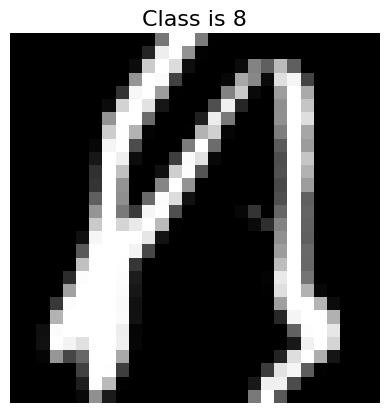

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





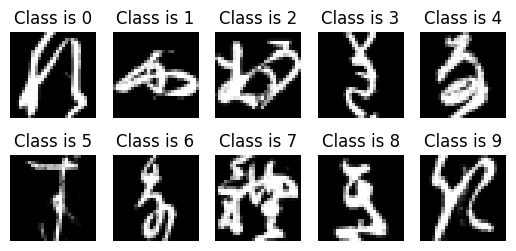

In [ ]:
uniq_classes = np.unique(trainset.targets.numpy())

plt.subplots(2, 5)
for class_idx in uniq_classes:
  for class_set, pict in enumerate(trainset):
    if class_set == class_idx:
      plt.subplot(2, 5, class_set + 1)
      plt.imshow(pict[0].view(28, 28).numpy(), cmap="gray")
      plt.axis("off")
      plt.title(f"Class is {class_set}", fontsize=12)
      break
plt.subplots_adjust(hspace=-0.5)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)  # представляем картинку в виде вектора
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        logits = self.fc3(x)  # не нужна функция активации, так как Pytorch работает с логитами, а не вероятностями
        
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** 235146

In [ ]:
learning_params = 0
neural_net = FCNet()
for param in neural_net.parameters():
    learning_params += param.view(-1).shape[0]
print(learning_params)

235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9126
Epoch=2 loss=0.4475
Epoch=3 loss=0.3580
Epoch=4 loss=0.3000
Epoch=5 loss=0.2579
Epoch=6 loss=0.2242
Epoch=7 loss=0.1955
Epoch=8 loss=0.1716
Epoch=9 loss=0.1508
Epoch=10 loss=0.1329


In [ ]:
print(f"Accuracy train = {get_accuracy(fc_net, trainloader)}")
print(f"Accuracy test = {get_accuracy(fc_net, testloader)}")

Accuracy train = 0.9697833333333333
Accuracy test = 0.8724


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
counter = 0
for pict, _ in trainset:
    mean += pict[0].mean()
    std += pict[0].std()
    counter += 1

mean = mean / len(trainset)
std = std / len(trainset)
print(f'Mean = {mean.item()}; std = {std.item()}')

Mean = 0.19177359342575073; std = 0.3385438024997711


In [ ]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6787
Epoch=2 loss=0.2958
Epoch=3 loss=0.2160
Epoch=4 loss=0.1668
Epoch=5 loss=0.1331
Epoch=6 loss=0.1080
Epoch=7 loss=0.0885
Epoch=8 loss=0.0724
Epoch=9 loss=0.0587
Epoch=10 loss=0.0483


In [ ]:
print(f"Accuracy train = {get_accuracy(fc_net, trainloader)}")
print(f"Accuracy test = {get_accuracy(fc_net, testloader)}")

Accuracy train = 0.9936666666666667
Accuracy test = 0.9015


Как изменилась `accuracy` после нормализации?


После нормализации accuracy увелилась.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
class FCNet_var_activation(nn.Module):
    def __init__(self, func_activation):
        super().__init__() #  это надо помнить!

        self.func_activation = func_activation
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)  # представляем картинку в виде вектора
        x = self.fc1(x)
        x = self.func_activation(x)
        x = self.fc2(x)
        x = self.func_activation(x)
        logits = self.fc3(x)  # не нужна функция активации, так как Pytorch работает с логитами, а не вероятностями
        
        return logits

In [ ]:
activation_accuracy_res = {}
f_activations_l = [nn.functional.sigmoid, nn.functional.gelu, nn.functional.tanh]
for func in f_activations_l:
    print(f'Using activation function is {func.__name__}:')
    fc_net = FCNet_var_activation(func)
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    n_epochs = 10
    loss_history = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

    print(f'Accuracy = {get_accuracy(fc_net, testloader)}')
    print('------------')
    activation_accuracy_res[func.__name__] = get_accuracy(fc_net, testloader)

Using activation function is sigmoid:
Epoch=1 loss=1.5650
Epoch=2 loss=0.7572
Epoch=3 loss=0.5478
Epoch=4 loss=0.4484
Epoch=5 loss=0.3796
Epoch=6 loss=0.3264
Epoch=7 loss=0.2827
Epoch=8 loss=0.2466
Epoch=9 loss=0.2161
Epoch=10 loss=0.1903
Accuracy = 0.8563
------------
Using activation function is gelu:
Epoch=1 loss=0.6547
Epoch=2 loss=0.2795
Epoch=3 loss=0.2010
Epoch=4 loss=0.1528
Epoch=5 loss=0.1227
Epoch=6 loss=0.0971
Epoch=7 loss=0.0782
Epoch=8 loss=0.0631
Epoch=9 loss=0.0496
Epoch=10 loss=0.0395
Accuracy = 0.901
------------
Using activation function is tanh:
Epoch=1 loss=0.7766
Epoch=2 loss=0.3863
Epoch=3 loss=0.2598
Epoch=4 loss=0.1855
Epoch=5 loss=0.1352
Epoch=6 loss=0.1021
Epoch=7 loss=0.0759
Epoch=8 loss=0.0554
Epoch=9 loss=0.0408
Epoch=10 loss=0.0292
Accuracy = 0.9013
------------


In [ ]:
sorted(activation_accuracy_res.items(), key=lambda item: item[1])[::-1][0]

('tanh', 0.9013)

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

С функцией активации тангенса.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
from torch.optim import Adam, RMSprop, Adagrad

In [ ]:
%%time
print('Optimizator Adam: ')
fc_net = FCNet_var_activation(nn.functional.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')

Optimizator Adam: 
Epoch=1 loss=0.7756
Epoch=2 loss=0.3773
Epoch=3 loss=0.2537
Epoch=4 loss=0.1841
Epoch=5 loss=0.1368
Epoch=6 loss=0.1034
Epoch=7 loss=0.0783
Epoch=8 loss=0.0583
Epoch=9 loss=0.0431
Epoch=10 loss=0.0327
Accuracy = 0.9024
CPU times: user 33 s, sys: 2.56 s, total: 35.6 s
Wall time: 3min 6s


In [ ]:
%%time
print('Optimizator RMSprop: ')
fc_net = FCNet_var_activation(nn.functional.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = RMSprop(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')

Optimizator RMSprop: 
Epoch=1 loss=0.5680
Epoch=2 loss=0.3127
Epoch=3 loss=0.2171
Epoch=4 loss=0.1605
Epoch=5 loss=0.1202
Epoch=6 loss=0.0906
Epoch=7 loss=0.0667
Epoch=8 loss=0.0495
Epoch=9 loss=0.0361
Epoch=10 loss=0.0267
Accuracy = 0.8994
CPU times: user 30.3 s, sys: 2.25 s, total: 32.5 s
Wall time: 2min 44s


In [ ]:
%%time
print('Optimizator Adagrad: ')
fc_net = FCNet_var_activation(nn.functional.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adagrad(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')

Optimizator Adagrad: 
Epoch=1 loss=1.4090
Epoch=2 loss=1.0270
Epoch=3 loss=0.9002
Epoch=4 loss=0.8281
Epoch=5 loss=0.7792
Epoch=6 loss=0.7433
Epoch=7 loss=0.7152
Epoch=8 loss=0.6924
Epoch=9 loss=0.6738
Epoch=10 loss=0.6573
Accuracy = 0.6759
CPU times: user 30.1 s, sys: 2.23 s, total: 32.3 s
Wall time: 2min 41s


Быстрее всех отработал оптимизатор Adagrad (2min 41s), а точнее всех оказался Adam (accuracy = 0.9024).

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        x = torch.maximum(torch.zeros_like(x), x)
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
# жалкая пародия
fc_net = FCNet_var_activation(CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')

Epoch=1 loss=0.6776
Epoch=2 loss=0.3035
Epoch=3 loss=0.2220
Epoch=4 loss=0.1710
Epoch=5 loss=0.1352
Epoch=6 loss=0.1097
Epoch=7 loss=0.0882
Epoch=8 loss=0.0724
Epoch=9 loss=0.0589
Epoch=10 loss=0.0478
Accuracy = 0.9022


In [ ]:
# неповторимый оригинал
fc_net = FCNet_var_activation(nn.functional.relu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

print(f'Accuracy = {get_accuracy(fc_net, testloader)}')

Epoch=1 loss=0.6858
Epoch=2 loss=0.3025
Epoch=3 loss=0.2231
Epoch=4 loss=0.1732
Epoch=5 loss=0.1385
Epoch=6 loss=0.1128
Epoch=7 loss=0.0924
Epoch=8 loss=0.0757
Epoch=9 loss=0.0618
Epoch=10 loss=0.0499
Accuracy = 0.8973


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Ежики кололись, но продолжали есть кактус.

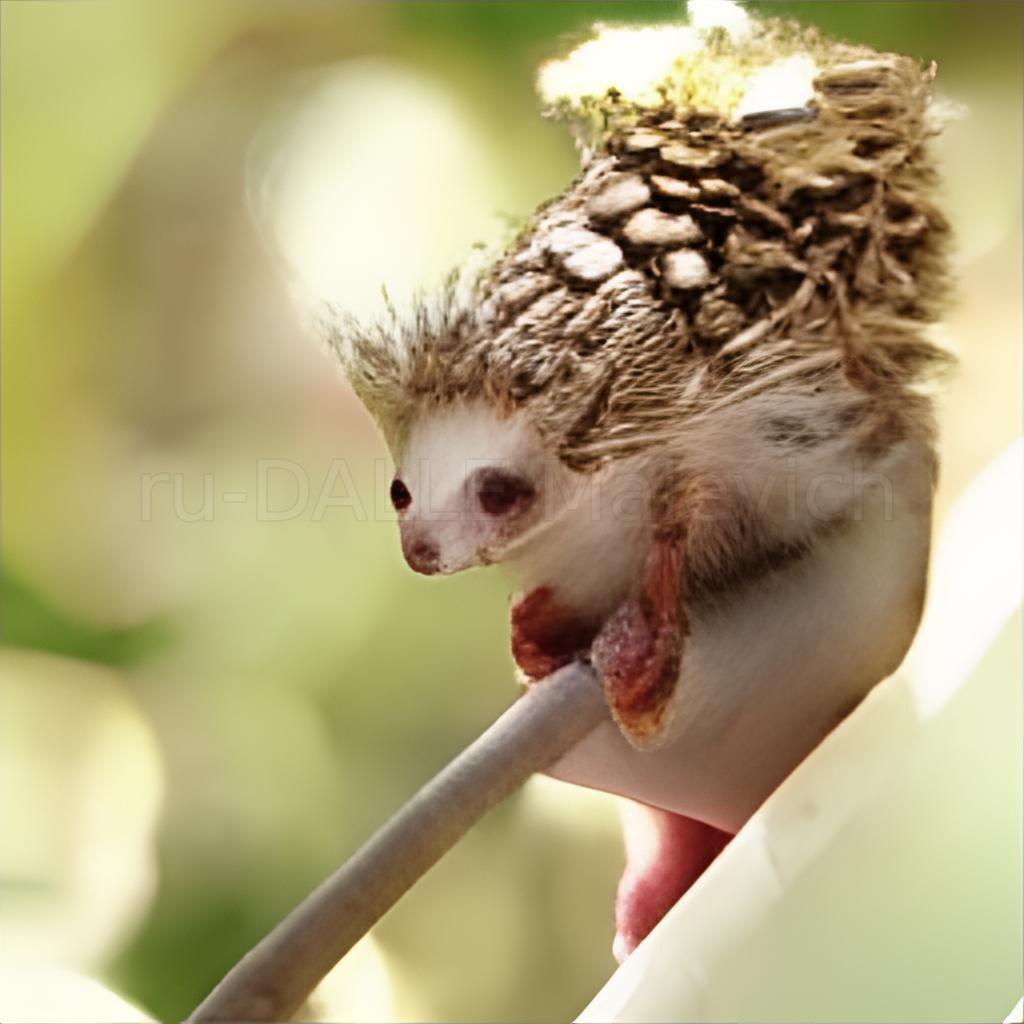

Суровые будни биоинформатика.

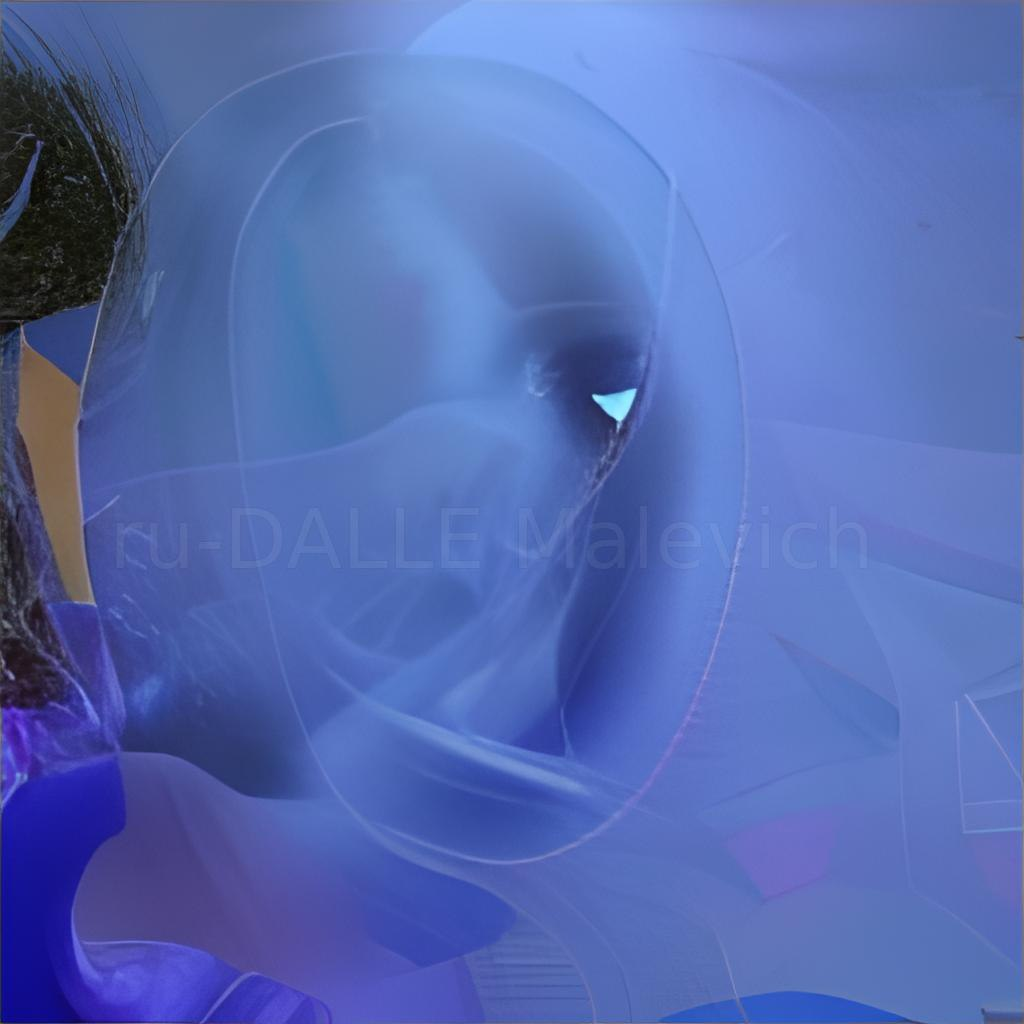

Солнечная поляна (просто красивое).

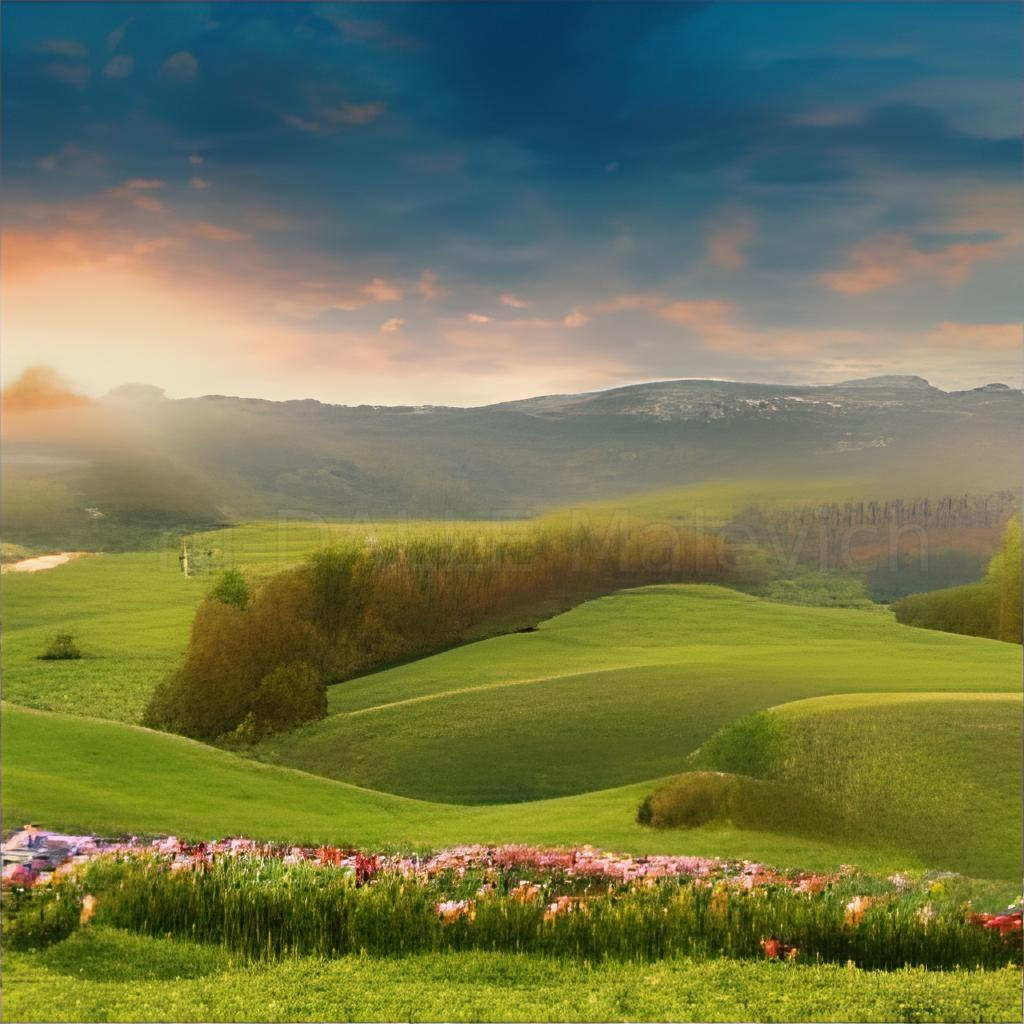